# Load libraries

In [1]:
# Importing packages
import requests
import zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import nbformat
from pykrige.ok import OrdinaryKriging
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from inmet_data_functions import read_inmet_data

# Read the dataset and show some basic informations

In [2]:
# Reading data for a specifc year
inmet_data = read_inmet_data(years = range(2023, 2025))

DATA\INMET_DATA_2024.csv
Data from 2024 has shape equal to (1643664, 27)


In [3]:
# Show data information
inmet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643664 entries, 0 to 1643663
Data columns (total 27 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   DATA                                 1643664 non-null  object 
 1   HORA                                 1643664 non-null  int64  
 2   PRECIPITACAO_TOTAL                   1244593 non-null  float64
 3   PRESSAO_ATM                          1396189 non-null  float64
 4   PRESSAO_ATM_MAX_HORA_ANT             1394816 non-null  float64
 5   PRESSAO_ATM_MIN_HORA_ANT             1394811 non-null  float64
 6   RADIACAO_GLOBAL                      882979 non-null   float64
 7   TEMPERATURA_AR                       1388493 non-null  float64
 8   TEMPERATURA_AR_ORVALHO               1288052 non-null  float64
 9   TEMPERATURA_AR_MAX_HORA_ANT          1387092 non-null  float64
 10  TEMPERATURA_AR_MIN_HORA_ANT          1387137 non-null  float64
 11

# Descriptive analysis of the numerical variables

In [7]:
# Define the numerical variables
num_var = ['PRECIPITACAO_TOTAL', 'PRESSAO_ATM', 'RADIACAO_GLOBAL', 'TEMPERATURA_AR', 'TEMPERATURA_AR_ORVALHO',
           'UMIDADE_REL', 'VENTO_DIRECAO_HORARIA', 'VENTO_RAJADA_MAXIMA', 'VENTO_VELOCIDADE_HORARIA',
           'LATITUDE', 'LONGITUDE', 'ALTITUDE']

In [8]:
# Summary of the dataset
inmet_data[num_var].describe()

PRECIPITACAO_TOTAL   PRESSAO_ATM  RADIACAO_GLOBAL  TEMPERATURA_AR  \
count        1.244593e+06  1.396189e+06    882979.000000    1.388493e+06   
mean         2.607556e-01  9.642733e+02      1233.027147    2.517654e+01   
std          1.818198e+00  3.769352e+01      1159.779008    4.210151e+00   
min          0.000000e+00  8.122000e+02         0.000000    3.200000e+00   
25%          0.000000e+00  9.377000e+02       108.200000    2.250000e+01   
50%          0.000000e+00  9.688000e+02       940.300000    2.490000e+01   
75%          0.000000e+00  9.965000e+02      2179.100000    2.800000e+01   
max          8.840000e+01  1.036400e+03      8208.900000    4.460000e+01   

       TEMPERATURA_AR_ORVALHO   UMIDADE_REL  VENTO_DIRECAO_HORARIA  \
count            1.288052e+06  1.297465e+06           1.308766e+06   
mean             2.073708e+01  7.835054e+01           1.592971e+02   
std              2.985009e+00  1.628507e+01           1.025157e+02   
min             -2.200000e+01  7.000000e+00           1.000000e+00   
25%              1.900000e+01  6.700000e+01           7.400000e+01   
50%              2.110000e+01  8.200000e+01           1.370000e+02   
75%              2.290000e+01  9.200000e+01           2.410000e+02   
max              4.490000e+01  1.000000e+02           3.600000e+02   

       VENTO_RAJADA_MAXIMA  VENTO_VELOCIDADE_HORARIA      LATITUDE  \
count         1.314009e+06              1.316257e+06  1.643664e+06   
mean          4.346648e+00              1.660980e+00 -1.584495e+01   
std           2.729271e+00              1.455519e+00  8.215549e+00   
min           0.000000e+00              0.000000e+00 -3.374222e+01   
25%           2.300000e+00              6.000000e-01 -2.235805e+01   
50%           4.000000e+00              1.400000e+00 -1.621361e+01   
75%           6.000000e+00              2.400000e+00 -8.950000e+00   
max           4.000000e+01              2.080000e+01  3.813611e+00   

          LONGITUDE      ALTITUDE  
count  1.643664e+06  1.643664e+06  
mean  -4.791502e+01  4.164212e+02  
std    6.869479e+00  3.390652e+02  
min   -7.278667e+01  2.000000e+00  
25%   -5.234861e+01  1.263900e+02  
50%   -4.796444e+01  3.676150e+02  
75%   -4.270750e+01  6.460000e+02  
max   -3.481556e+01  1.790380e+03

<Axes: >

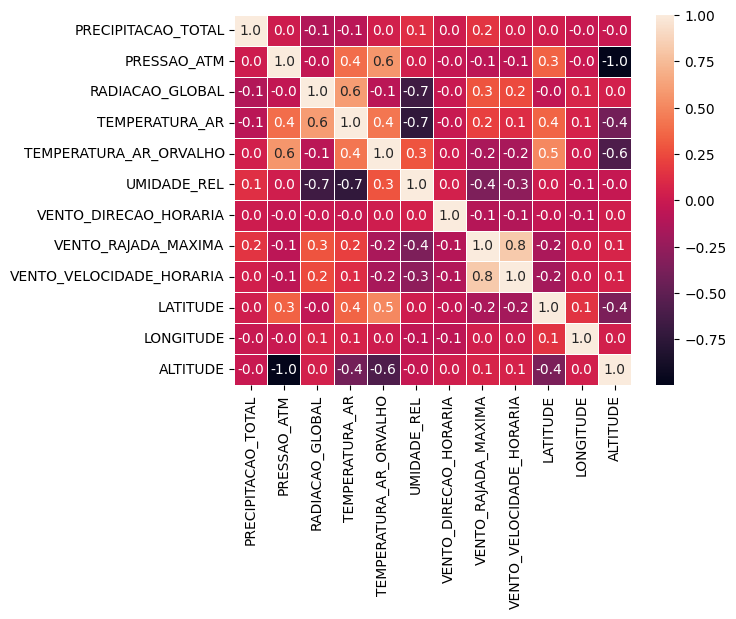

In [9]:
# Correlation Matrix
correlation = inmet_data[num_var].corr()
sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)

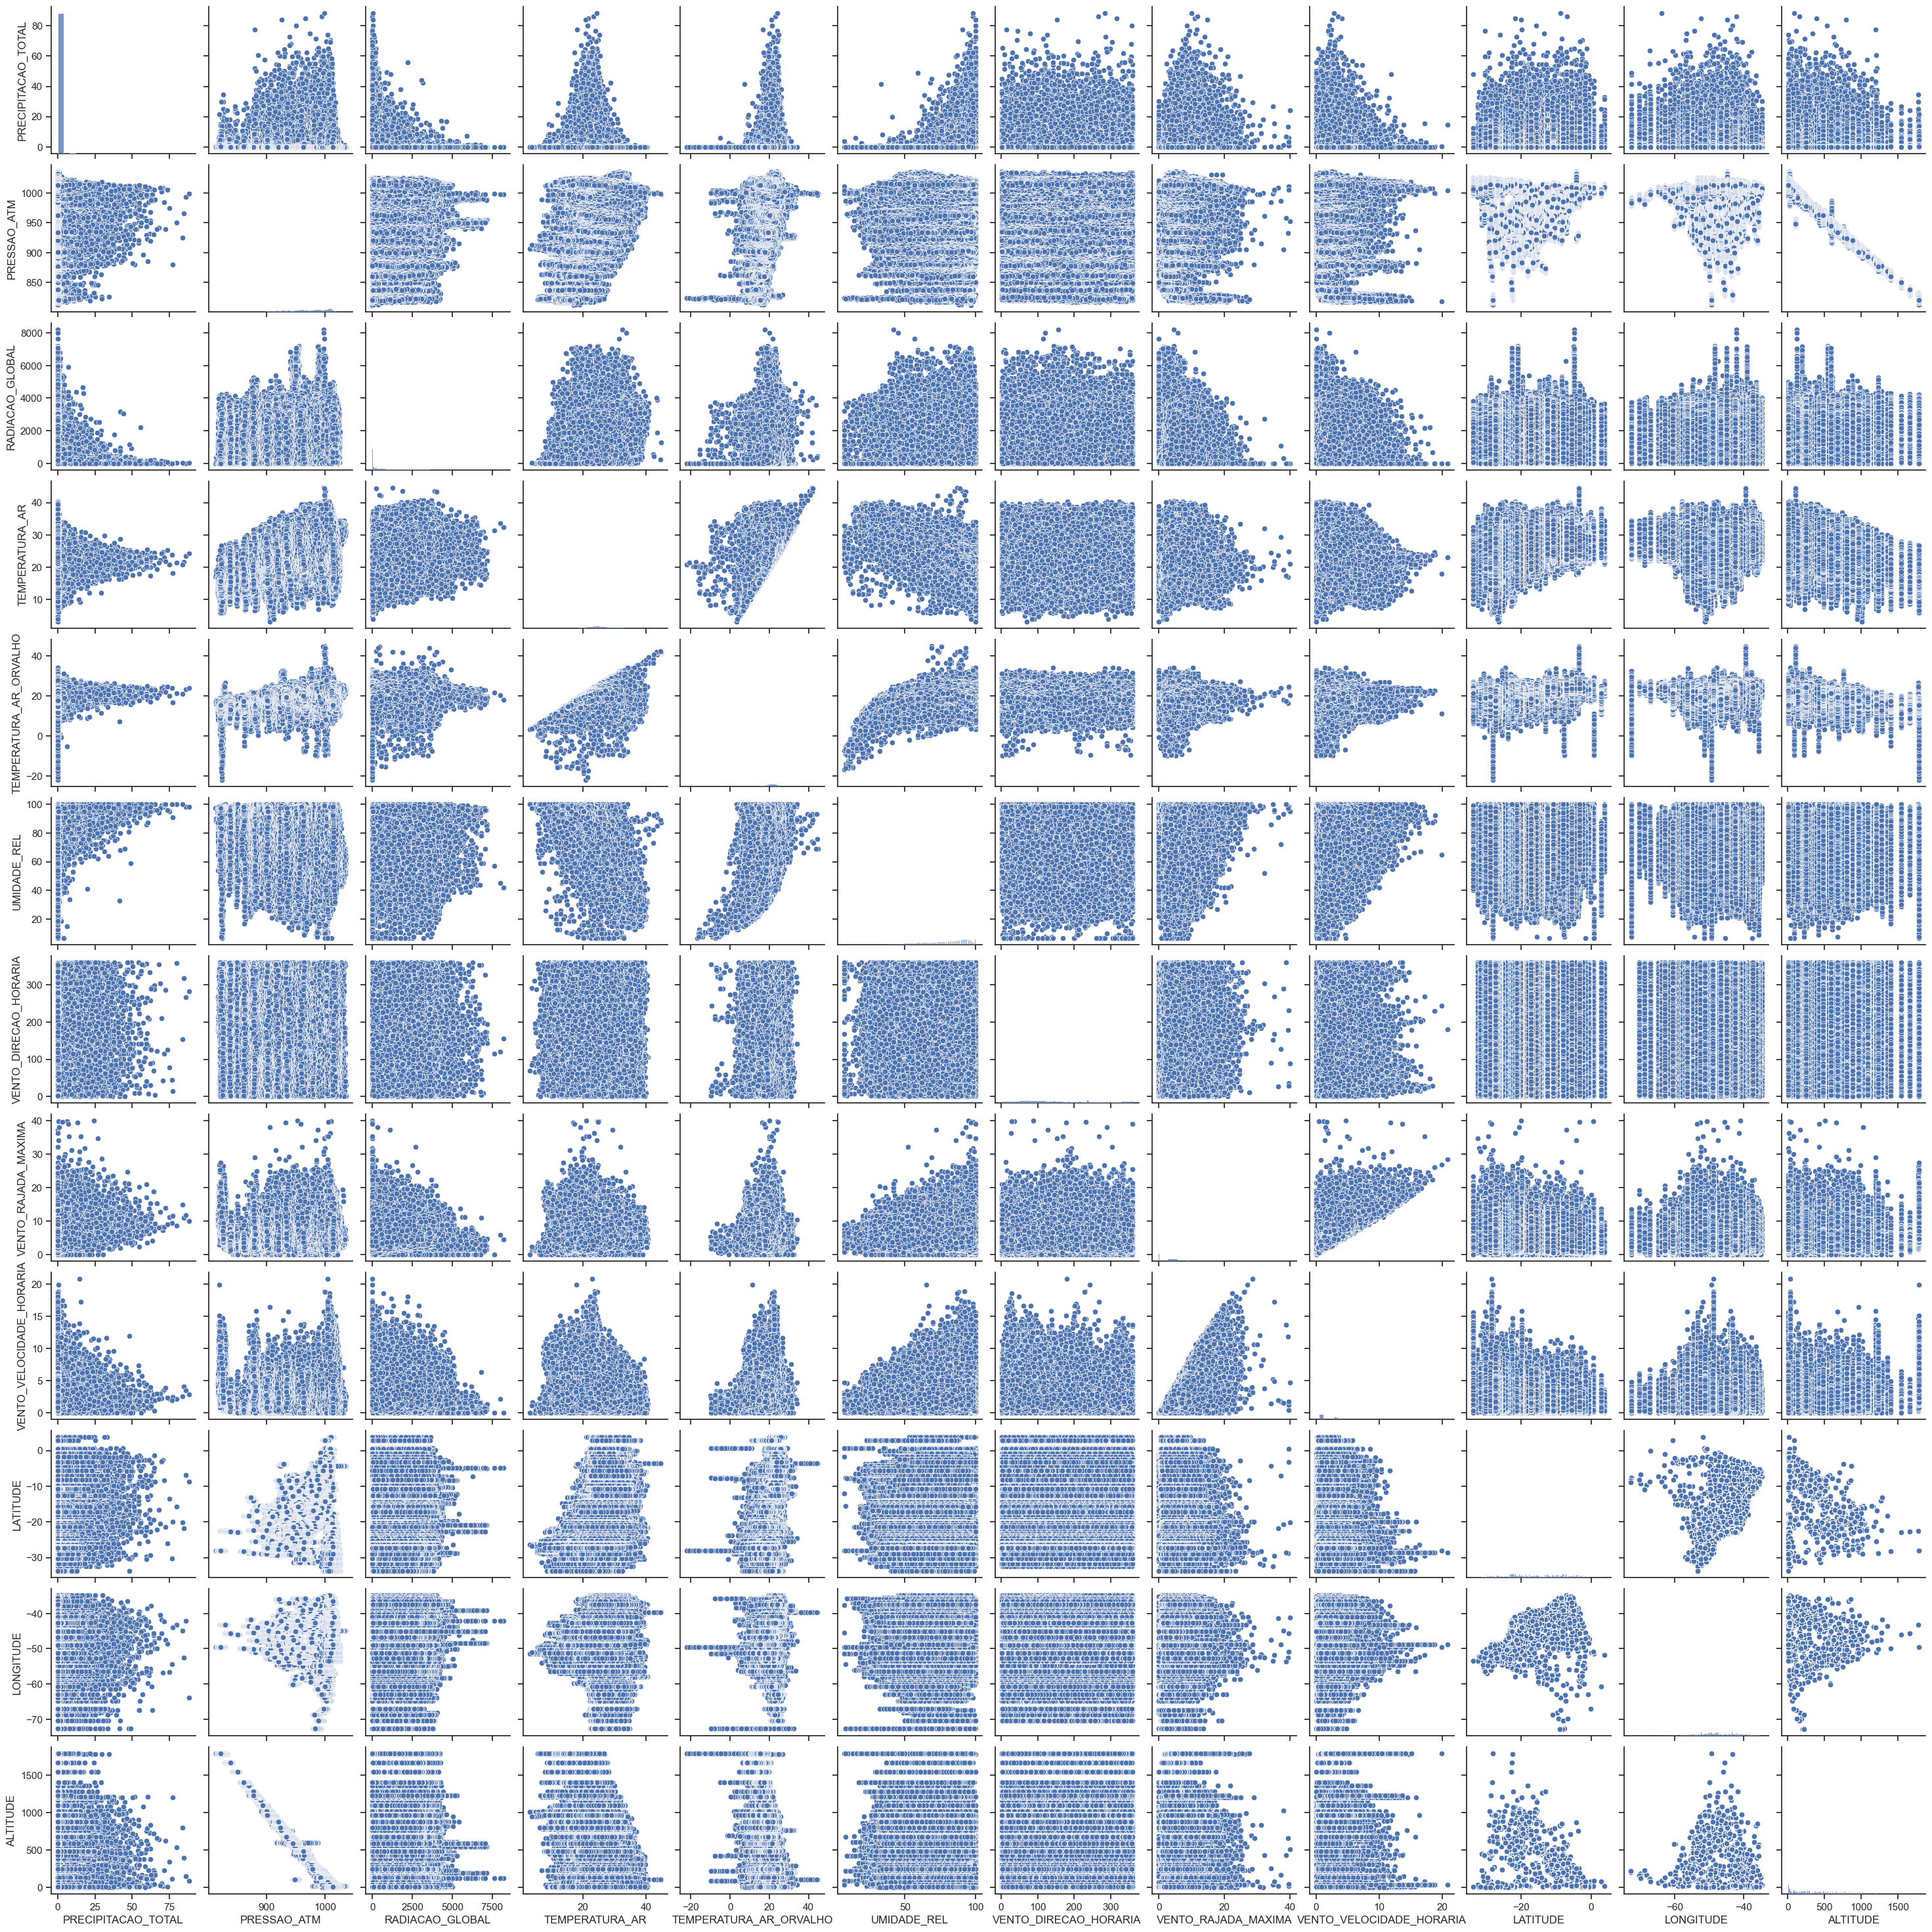

In [10]:
# Scatterplot of the numerical variables 
sns.set_theme(style="ticks")
sns.pairplot(inmet_data[num_var])
#sns.pairplot(data_train_num, hue="outcome")

# Spatial analysis of the dataset

### Max wind

In [15]:
# Perform a groupby operation and compute the mean for each category
grouped_data = inmet_data.groupby(['ESTACAO','LATITUDE', 'LONGITUDE', 'ALTITUDE'])[['VENTO_VELOCIDADE_HORARIA','VENTO_RAJADA_MAXIMA']].max()

# Reset the index to transform the result into a DataFrame with 'ESTACAO', 'LATITUDE', and 'LONGITUDE' as columns
grouped_data = grouped_data.reset_index()

# Removing missing values
grouped_data = grouped_data.dropna()

# Create an interactive map
fig = px.scatter_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    zoom = 3,
    color = grouped_data['VENTO_RAJADA_MAXIMA'],
    size = grouped_data['VENTO_RAJADA_MAXIMA'],
    color_continuous_scale='Viridis',
    text = grouped_data['ESTACAO'],
    width = 900,
    height = 600,
    title = 'Interactive Map for Max Hourly Wind Speed by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [18]:
# Create an interactive density map
fig = px.density_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    z = grouped_data["VENTO_RAJADA_MAXIMA"],
    radius = 15,
    zoom = 3,
    width = 900,
    height = 600,
    title = 'Interactive Map for Max Hourly Wind Speed by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

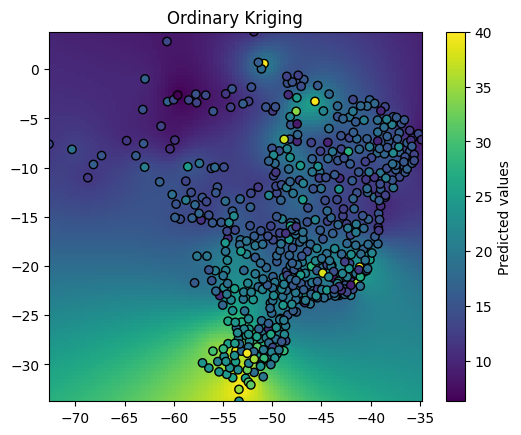

In [4]:
x = grouped_data['LONGITUDE']
y = grouped_data['LATITUDE']
values = grouped_data['VENTO_RAJADA_MAXIMA']

# Create the kriging object
OK = OrdinaryKriging(x, y, values, variogram_model='linear', verbose=False, enable_plotting=False)

# Define the grid where predictions are needed
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

# Perform the kriging interpolation
z, ss = OK.execute('grid', gridx, gridy)

# Plot the results
plt.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
plt.scatter(x, y, c=values, edgecolor='k')
plt.colorbar(label='Predicted values')
plt.title('Ordinary Kriging')
plt.show()

### Preciptation

In [19]:
## Data Analysys - Preciptation
# Perform a groupby operation and compute the mean for each category
grouped_data = inmet_data.groupby(['ESTACAO','LATITUDE', 'LONGITUDE', 'ALTITUDE'])[['PRECIPITACAO_TOTAL']].sum()

# Reset the index to transform the result into a DataFrame with 'ESTACAO', 'LATITUDE', and 'LONGITUDE' as columns
grouped_data = grouped_data.reset_index()

# Removing missing values
grouped_data= grouped_data.dropna()

# Create an interactive map
fig = px.scatter_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    zoom = 3,
    color = grouped_data['PRECIPITACAO_TOTAL'],
    size = grouped_data['PRECIPITACAO_TOTAL'],
    color_continuous_scale='Viridis',
    text = grouped_data['ESTACAO'],
    width = 900,
    height = 600,
    title = 'Interactive Map for Total Preciptation by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


In [ ]:
# Create an interactive density map
fig = px.density_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    z = grouped_data["PRECIPITACAO_TOTAL"],
    radius = 15,
    zoom = 3,
    width = 900,
    height = 600,
    title = 'Interactive Map for Total Preciptation by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

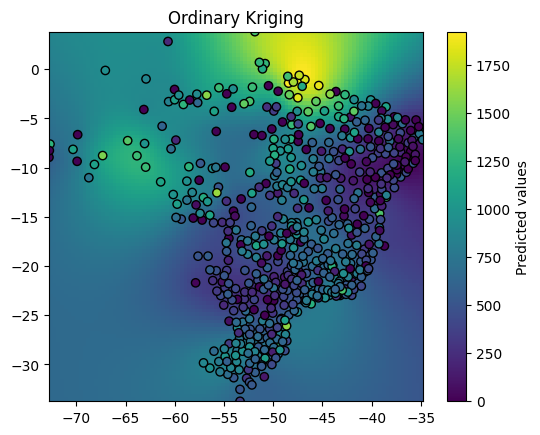

In [6]:
x = grouped_data['LONGITUDE']
y = grouped_data['LATITUDE']
values = grouped_data['PRECIPITACAO_TOTAL']

# Create the kriging object
OK = OrdinaryKriging(x, y, values, variogram_model='linear', verbose=False, enable_plotting=False)

# Define the grid where predictions are needed
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

# Perform the kriging interpolation
z, ss = OK.execute('grid', gridx, gridy)

# Plot the results
plt.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
plt.scatter(x, y, c=values, edgecolor='k')
plt.colorbar(label='Predicted values')
plt.title('Ordinary Kriging')
plt.show()

### Temperature 

In [7]:
## Data Analysis - Temperature
# Perform a groupby operation and compute the mean for each category
grouped_data = inmet_data.groupby(['ESTACAO','LATITUDE', 'LONGITUDE', 'ALTITUDE'])[['TEMPERATURA_AR']].mean()

# Reset the index to transform the result into a DataFrame with 'ESTACAO', 'LATITUDE', and 'LONGITUDE' as columns
grouped_data = grouped_data.reset_index()

# Removing missing values
grouped_data= grouped_data.dropna()

# Create an interactive map
fig = px.scatter_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    zoom = 3,
    color = grouped_data['TEMPERATURA_AR'],
    size = grouped_data['TEMPERATURA_AR'],
    color_continuous_scale='Viridis',
    text = grouped_data['ESTACAO'],
    width = 900,
    height = 600,
    title = 'Interactive Map for Temperature by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [ ]:
# Create an interactive density map
fig = px.density_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    z = grouped_data["TEMPERATURA_AR"],
    radius = 15,
    zoom = 3,
    width = 900,
    height = 600,
    title = 'Interactive Map for Temperature by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

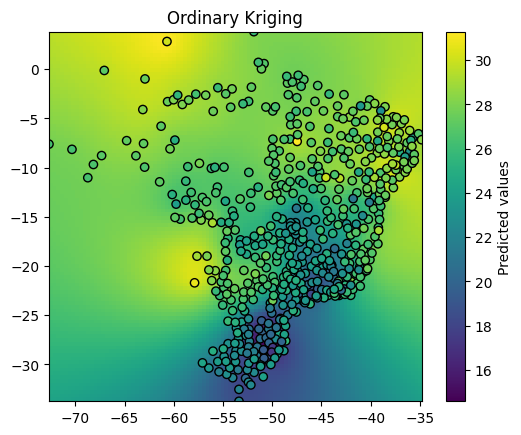

In [8]:
x = grouped_data['LONGITUDE']
y = grouped_data['LATITUDE']
values = grouped_data['TEMPERATURA_AR']

# Create the kriging object
OK = OrdinaryKriging(x, y, values, variogram_model='linear', verbose=False, enable_plotting=False)

# Define the grid where predictions are needed
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

# Perform the kriging interpolation
z, ss = OK.execute('grid', gridx, gridy)

# Plot the results
plt.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
plt.scatter(x, y, c=values, edgecolor='k')
plt.colorbar(label='Predicted values')
plt.title('Ordinary Kriging')
plt.show()

### Pressure

In [9]:
## Data Analysis - Pressure
# Perform a groupby operation and compute the mean for each category
grouped_data = inmet_data.groupby(['ESTACAO','LATITUDE', 'LONGITUDE', 'ALTITUDE'])[['PRESSAO_ATM']].mean()

# Reset the index to transform the result into a DataFrame with 'ESTACAO', 'LATITUDE', and 'LONGITUDE' as columns
grouped_data = grouped_data.reset_index()

# Removing missing values
grouped_data= grouped_data.dropna()

# Create an interactive map
fig = px.scatter_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    zoom = 3,
    color = grouped_data['PRESSAO_ATM'],
    size = grouped_data['PRESSAO_ATM'],
    color_continuous_scale='Viridis',
    text = grouped_data['ESTACAO'],
    width = 900,
    height = 600,
    title = 'Interactive Map for Pressure by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [ ]:
# Create an interactive density map
fig = px.density_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    z = grouped_data["PRESSAO_ATM"],
    radius = 15,
    zoom = 3,
    width = 900,
    height = 600,
    title = 'Interactive Map for Pressure by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

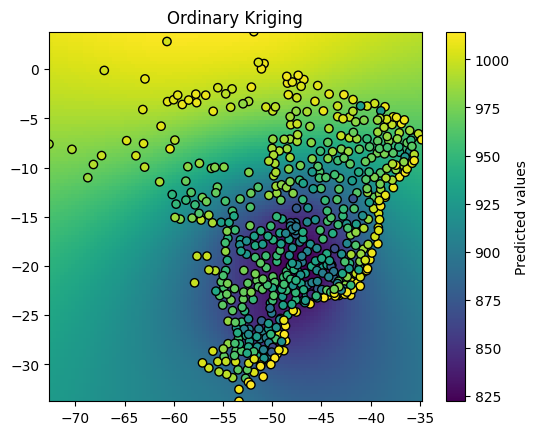

In [10]:
x = grouped_data['LONGITUDE']
y = grouped_data['LATITUDE']
values = grouped_data['PRESSAO_ATM']

# Create the kriging object
OK = OrdinaryKriging(x, y, values, variogram_model='linear', verbose=False, enable_plotting=False)

# Define the grid where predictions are needed
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

# Perform the kriging interpolation
z, ss = OK.execute('grid', gridx, gridy)

# Plot the results
plt.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
plt.scatter(x, y, c=values, edgecolor='k')
plt.colorbar(label='Predicted values')
plt.title('Ordinary Kriging')
plt.show()

In [11]:
## Data Analysis - Humidity
# Perform a groupby operation and compute the mean for each category
grouped_data = inmet_data.groupby(['ESTACAO','LATITUDE', 'LONGITUDE', 'ALTITUDE'])[['UMIDADE_REL']].mean()

# Reset the index to transform the result into a DataFrame with 'ESTACAO', 'LATITUDE', and 'LONGITUDE' as columns
grouped_data = grouped_data.reset_index()

# Removing missing values
grouped_data= grouped_data.dropna()

# Create an interactive map
fig = px.scatter_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    zoom = 3,
    color = grouped_data['UMIDADE_REL'],
    size = grouped_data['UMIDADE_REL'],
    color_continuous_scale='Viridis',
    text = grouped_data['ESTACAO'],
    width = 900,
    height = 600,
    title = 'Interactive Map for Humidity by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [ ]:
# Create an interactive density map
fig = px.density_mapbox(grouped_data,
    lon = grouped_data['LONGITUDE'],
    lat = grouped_data['LATITUDE'],
    z = grouped_data["UMIDADE_REL"],
    radius = 15,
    zoom = 3,
    width = 900,
    height = 600,
    title = 'Interactive Map for Humidity by Station'
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

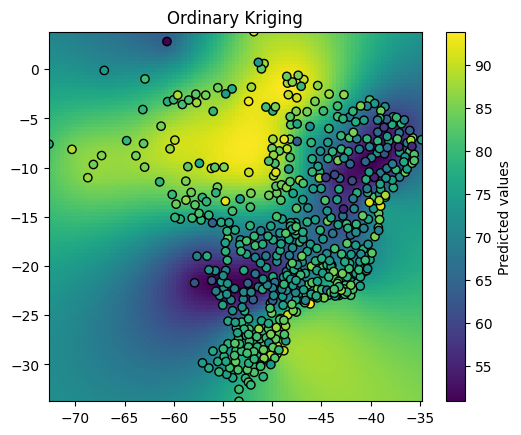

In [15]:
x = grouped_data['LONGITUDE']
y = grouped_data['LATITUDE']
values = grouped_data['UMIDADE_REL']

# Create the kriging object
OK = OrdinaryKriging(x, y, values, variogram_model='linear', verbose=False, enable_plotting=False)

# Define the grid where predictions are needed
gridx = np.linspace(x.min(), x.max(), 100)
gridy = np.linspace(y.min(), y.max(), 100)

# Perform the kriging interpolation
z, ss = OK.execute('grid', gridx, gridy)

# Plot the results
plt.imshow(z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
plt.scatter(x, y, c=values, edgecolor='k')
plt.colorbar(label='Predicted values')
plt.title('Ordinary Kriging')
plt.show()